# Modeling the Data with Logistic Regression

In [1]:
# import libraries
from dotenv import load_dotenv, find_dotenv
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix

%load_ext watermark
%load_ext autoreload
%autoreload 2

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)

# import my method from the source code
from features.build_features import clean_and_tokenize

# import my visual tools
from visualization.visualize import plot_confusion_matrix, draw_roc_curve

In [3]:
%watermark -a "E. Chris Lynch" -d -t -v -p numpy,pandas,nltk,sklearn

E. Chris Lynch 2019-02-06 16:31:37 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.24.0
nltk 3.4
sklearn 0.20.2


In [4]:
# load the data
df = pd.read_csv(os.path.join(PROJ_ROOT, 'data', 'processed','clinic_train_data.csv'), index_col=0)

# define text feature
text = df.text.values

# define target
target = df.readmission.values

In [5]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    text, target, stratify=target, test_size=0.33, random_state=42)

## Under-sampling with RandomUnderSample

In [6]:
vec_params = {'max_features': 3000, 'tokenizer': clean_and_tokenize, 'stop_words': 'english'}
lr_params = {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs', 'random_state': 42}

pipe_rus = make_pipeline_imb(CountVectorizer(**vec_params),
                         RandomUnderSampler(random_state=42),
                         LogisticRegression(**lr_params))

pipe_rus_fit = pipe_rus.fit(X_train, y_train)
y_pred_rus = pipe_rus_fit.predict(X_test)

In [7]:
# print metrics summary
print(classification_report_imbalanced(y_test, y_pred_rus))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.72      0.57      0.82      0.64      0.42     11097
          1       0.11      0.57      0.72      0.19      0.64      0.40       711

avg / total       0.91      0.71      0.58      0.78      0.64      0.41     11808



Confusion matrix, without normalization
[[7942 3155]
 [ 304  407]]


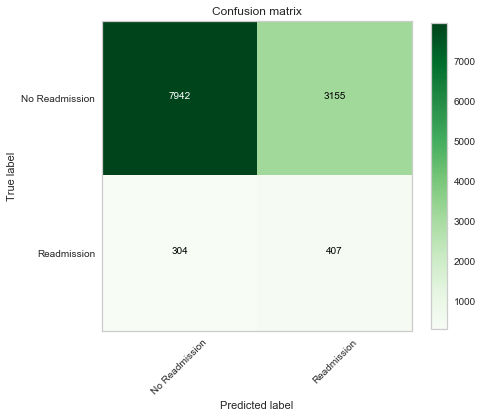

In [8]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred_rus)
    
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['No Readmission','Readmission'],
                      title='Confusion matrix', cmap=plt.cm.Greens)
plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                         'figures','lr_undersample_confusion_matrix.png'))
plt.show()

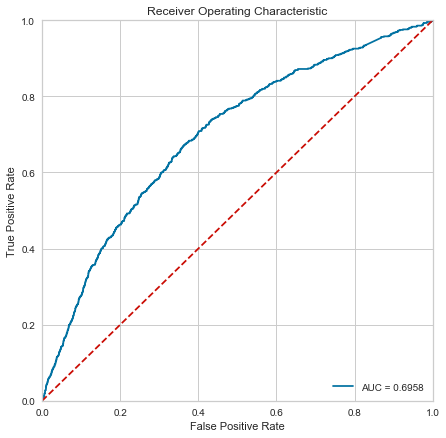

In [9]:
plt.figure(figsize=(7,7))
draw_roc_curve(model=pipe_rus, features=X_test, target=y_test)
plt.savefig(os.path.join(PROJ_ROOT, 'reports', 'figures', 'lr_undersample_roc_curve.png'))
plt.show()

## Over-sampling with SVMSMOTE

In [11]:
from imblearn.over_sampling import SVMSMOTE

lr_params = {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 700, 'random_state': 42}

pipe_smote = make_pipeline_imb(CountVectorizer(**vec_params),
                         SVMSMOTE(random_state=42),
                         LogisticRegression(**lr_params))

pipe_smote.fit(X_train, y_train)
y_pred_smote = pipe_smote.predict(X_test)

# print metrics summary
print(classification_report_imbalanced(y_test, y_pred_smote))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.96      0.12      0.95      0.34      0.13     11097
          1       0.16      0.12      0.96      0.14      0.34      0.11       711

avg / total       0.90      0.91      0.17      0.90      0.34      0.12     11808



Confusion matrix, without normalization
[[10631   466]
 [  625    86]]


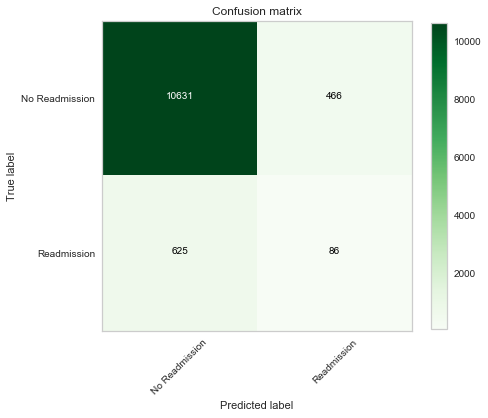

In [12]:
cnf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
    
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix_smote, 
                      classes=['No Readmission','Readmission'],
                      cmap=plt.cm.Greens)

plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                         'figures','lr_oversample_confusion_matrix.png'))
plt.show()

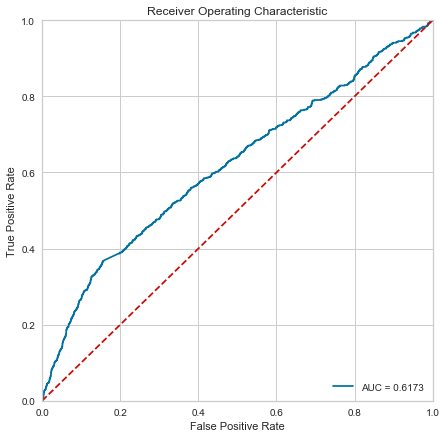

In [13]:
plt.figure(figsize=(7,7))
draw_roc_curve(model=pipe_smote, features=X_test, target=y_test)
plt.savefig(os.path.join(PROJ_ROOT, 'reports', 'figures', 'lr_oversample_roc_curve.png'))

plt.show()

## Fine Tuning 

In [15]:
def draw_validation_curve(model, features, labels, 
                          param_range=np.linspace(10e-5, 10e-1, 5), param='lr__C', name='C',
                          metric='roc_auc', cv=3, n_jobs=1, title='Logistic Regression'):
    
    train_scores, test_scores = validation_curve(model, 
                                                 features, labels, 
                                                 param_name=param, 
                                                 param_range=param_range,
                                                 cv=cv, scoring=metric, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with %s" % title)
    plt.xlabel(name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

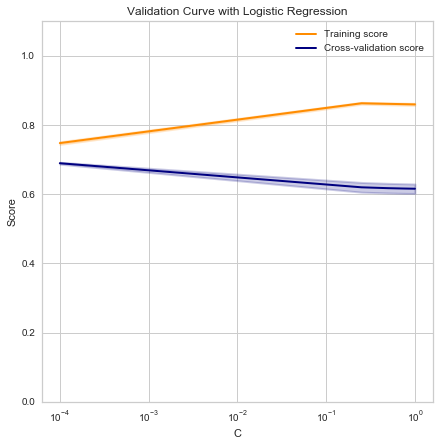

In [16]:
from sklearn.model_selection import validation_curve
from imblearn.pipeline import Pipeline as pipeline_imb

vec_params = {'max_features': 3000, 'tokenizer': clean_and_tokenize, 'stop_words': 'english'}

vectorizer = CountVectorizer(**vec_params)
rus = RandomUnderSampler(random_state=42)
lr = LogisticRegression(solver= 'lbfgs', max_iter=700, random_state=42)

validate_pipe = pipeline_imb(steps=[('vec',vectorizer),
                                    ('rus',rus),
                                    ('lr',lr)
                                   ])

# plot validation curve
plt.figure(figsize=(7,7))
draw_validation_curve(model=validate_pipe, features=X_train, labels=y_train, n_jobs=-1)
plt.show()

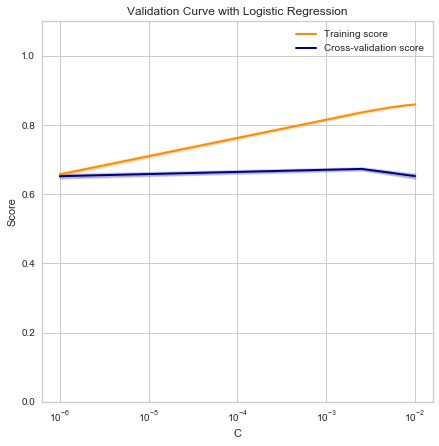

In [17]:
# plot validation curve
plt.figure(figsize=(7,7))
draw_validation_curve(model=validate_pipe, features=X_train, labels=y_train, param_range=np.linspace(10e-7, 10e-3, 5))
plt.show()

In [18]:
lr_params = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':700, 'random_state': 42}

pipe_rus2 = make_pipeline_imb(CountVectorizer(**vec_params),
                         RandomUnderSampler(random_state=42),
                         LogisticRegression(**lr_params))

pipe_rus2_fit = pipe_rus2.fit(X_train, y_train)
y_pred_rus2 = pipe_rus2_fit.predict(X_test)

# print metrics summary
print(classification_report_imbalanced(y_test, y_pred_rus2))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.67      0.61      0.79      0.64      0.41     11097
          1       0.10      0.61      0.67      0.18      0.64      0.40       711

avg / total       0.91      0.66      0.61      0.75      0.64      0.41     11808



Confusion matrix, without normalization
[[7398 3699]
 [ 280  431]]


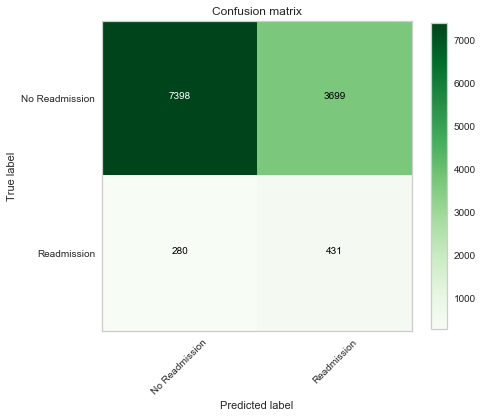

In [19]:
cnf_matrix_rus2 = confusion_matrix(y_test, y_pred_rus2)
    
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix_rus2, 
                      classes=['No Readmission','Readmission'],
                      cmap=plt.cm.Greens)

plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                         'figures','lr_undersample_confusion_matrix2.png'))
plt.show()

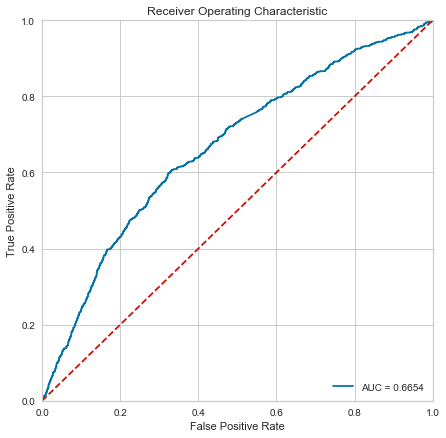

In [20]:
plt.figure(figsize=(7,7))
draw_roc_curve(model=pipe_rus2, features=X_test, target=y_test)
plt.savefig(os.path.join(PROJ_ROOT, 'reports', 'figures', 'lr_undersample_roc_curve2.png'))
plt.show()